# Lets try to forecast the demand of each product

In [1]:
import pandas as pd
df = pd.read_csv("Groceries_dataset.csv", sep=',', engine='c')

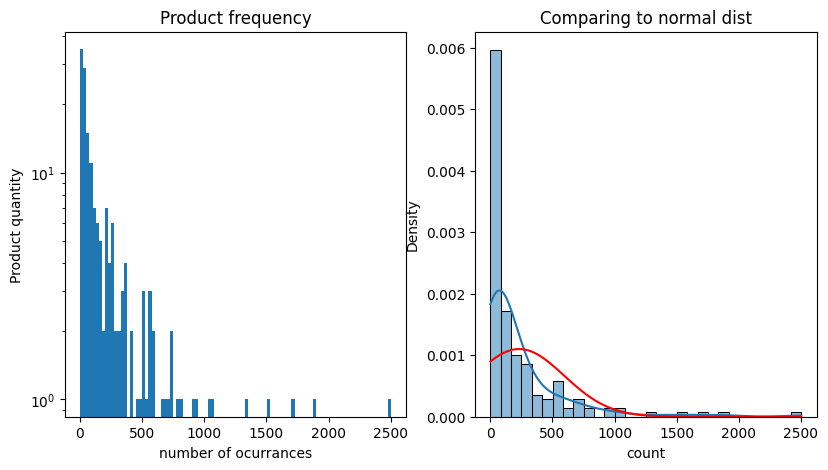

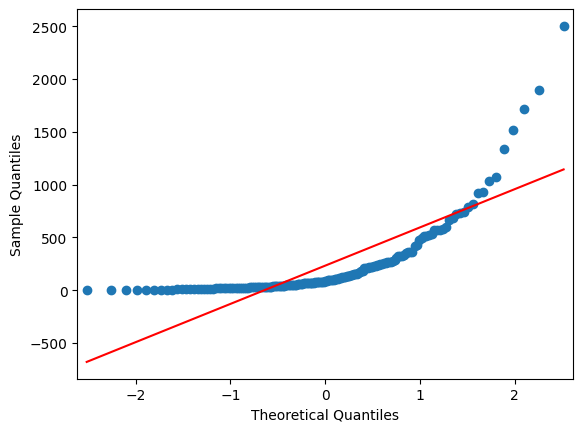

167

In [2]:
import seaborn as sns
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
product_counts = df['itemDescription'].value_counts()
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.hist(product_counts, bins=100, log=True)# escala log 
plt.xlabel('number of ocurrances')
plt.ylabel('Product quantity')
plt.title('Product frequency')

plt.subplot(1, 3, 2)
sns.histplot(product_counts, kde=True, stat='density', bins=30)
x = np.linspace(min(product_counts), max(product_counts), 100)
plt.plot(
    x,
    norm.pdf(x, np.mean(product_counts), np.std(product_counts)),
    color='red'
)
plt.title('Comparing to normal dist')

from statsmodels.graphics.gofplots import qqplot
plt.subplot(1, 3, 2)
qqplot(product_counts, line='s')
plt.show()

len(product_counts)


In [ ]:
#making sure there are no repeats of products
df.sort_values(by="Member_number", inplace=True)
df.reset_index(inplace=True, drop=True)
df.groupby(['Member_number', 'itemDescription']).size().reset_index(name='Count').head(20)


,Member_number,itemDescription,Count
0,1000,canned beer,1
1,1000,hygiene articles,1
2,1000,misc. beverages,1
3,1000,pastry,1
4,1000,pickled vegetables,1
5,1000,salty snack,1
6,1000,sausage,2
7,1000,semi-finished bread,1
8,1000,soda,1
9,1000,whole milk,2


### Now we will clusterize the products to facilitate each type of product demand forecasting

In [44]:
basket = df.groupby(['Member_number', 'itemDescription']).size().unstack(fill_value=0)
basket = basket > 0

In [ ]:
from mlxtend.frequent_patterns import fpgrowth, association_rules

MIN_lift = 1.8
MIN_leverage = 0.0

#Using fp-growth
frequent_itemsets = fpgrowth(basket, min_support=0.05, use_colnames=True, max_len=3)
# getting the asociation rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
#selecting only good realtions
rules = rules[(rules['leverage']>MIN_leverage)]
rules['lift x leverage']=rules['lift']*rules['leverage']

In [47]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml.fpm import FPGrowth

# Start Spark session
spark = SparkSession.builder.appName("GroceriesFP").getOrCreate()

# Load your data into Spark DataFrame
df_pd = pd.read_csv("Groceries_dataset.csv")
df_spark = spark.createDataFrame(df_pd)

# Group transactions by Member_number
transactions = df_spark.groupBy("Member_number").agg(
    F.collect_set("itemDescription").alias("items")
)
from pyspark.ml.fpm import FPGrowth

fpGrowth = FPGrowth(itemsCol="items", minSupport=0.05, minConfidence=0.2)
model = fpGrowth.fit(transactions)

# Frequent itemsets
frequent_itemsets = model.freqItemsets
frequent_itemsets.show(truncate=False)

# Association rules
rules = model.associationRules

rules.show(n=rules.count(),truncate=False)

+------------------------------------------+----+
|items                                     |freq|
+------------------------------------------+----+
|[whole milk]                              |1786|
|[other vegetables]                        |1468|
|[other vegetables, whole milk]            |746 |
|[rolls/buns]                              |1363|
|[rolls/buns, whole milk]                  |696 |
|[rolls/buns, other vegetables]            |572 |
|[rolls/buns, other vegetables, whole milk]|320 |
|[soda]                                    |1222|
|[soda, whole milk]                        |589 |
|[soda, other vegetables]                  |484 |
|[soda, other vegetables, whole milk]      |270 |
|[soda, rolls/buns]                        |467 |
|[soda, rolls/buns, whole milk]            |254 |
|[soda, rolls/buns, other vegetables]      |205 |
|[yogurt]                                  |1103|
|[yogurt, whole milk]                      |587 |
|[yogurt, other vegetables]                |469 |


In [46]:
rules.sample(20)

PySparkTypeError: [NOT_BOOL_OR_FLOAT_OR_INT] Argument `withReplacement (optional), fraction (required) and seed (optional)` should be a bool, float or int, got int, NoneType, NoneType.

In [42]:
import networkx as nx
from networkx.algorithms.community import k_clique_communities

# create the 
G = nx.Graph()
for _, row in rules.iterrows():
    for a in row['antecedents']:
        for c in row['consequents']:
            if G.has_edge(a, c):
                G[a][c]['weight'] += row['lift x leverage']
            else:
                G.add_edge(a, c, weight=row['lift x leverage'])

#create the cluster
k = 2 #at least a relation of 3 products for a communitie
communities = list(k_clique_communities(G, k))
overlapping_clusters = [set(comm) for comm in communities]

for i, c in enumerate(overlapping_clusters):
    print(f"Cluster {i}: {c}")

Cluster 0: {'margarine', 'domestic eggs', 'tropical fruit', 'frozen vegetables', 'pip fruit', 'yogurt', 'fruit/vegetable juice', 'chicken', 'butter', 'beef', 'shopping bags', 'brown bread', 'rolls/buns', 'bottled beer', 'pork', 'pastry', 'frankfurter', 'newspapers', 'whipped/sour cream', 'other vegetables', 'bottled water', 'soda', 'citrus fruit', 'canned beer', 'curd', 'coffee', 'sausage', 'whole milk', 'root vegetables'}


Computing the sells of each community, day by day

In [ ]:
df_grouped_item_names.head()
df_grouped_item_names['Date'] = df_grouped_item_names['Date'].dt.normalize()

min_date = df_grouped_item_names['Date'].min()
max_date = df_grouped_item_names['Date'].max()
date_range = pd.date_range(start=min_date, end=max_date, freq='M')

product_sales = pd.DataFrame(columns=['Itemname'] + list(date_range))
cluster_sales_as_dict={}
for c in overlapping_clusters:
    for p in c:
        if(len(product_sales[product_sales['Itemname']==str(p)])!=0):
            continue
        row = {'Itemname': p}
        p_appearences = df_grouped_item_names[df_grouped_item_names['Itemname']==str(p)]
        for i, month in enumerate(date_range):
            if(i==(len(date_range)-1)):
                row[month] = p_appearences[p_appearences['Date']>month]['Quantity'].sum()
            else:
                row[month] = p_appearences[(p_appearences['Date']>month) & (p_appearences['Date']<date_range[i+1])]['Quantity'].sum()
        product_sales = pd.concat([product_sales, pd.DataFrame([row])], ignore_index=True)


exclude_cols = ['Itemname']
month_cols = [col for col in product_sales.columns if col not in exclude_cols]
total_product_sales = product_sales[month_cols].sum(axis=1)
#normalyzing so we have no problem when summing it with others for the cluster seasonality analisys
product_sales[month_cols] = product_sales[month_cols].div(total_product_sales, axis=0)
product_sales.head()



/tmp/ipykernel_8374/1886009974.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  date_range = pd.date_range(start=min_date, end=max_date, freq='M')


,Itemname,2010-12-31 00:00:00,2011-01-31 00:00:00,2011-02-28 00:00:00,2011-03-31 00:00:00,2011-04-30 00:00:00,2011-05-31 00:00:00,2011-06-30 00:00:00,2011-07-31 00:00:00,2011-08-31 00:00:00,2011-09-30 00:00:00,2011-10-31 00:00:00,2011-11-30 00:00:00
0,HOT WATER BOTTLE I AM SO POORLY,0.029215,0.015442,0.008765,0.013773,0.01586,0.009599,0.012104,0.153589,0.134808,0.162354,0.339733,0.104758
1,HOT WATER BOTTLE TEA AND SYMPATHY,0.000335,0.0,0.000669,0.0,0.0,0.0,0.0,0.024757,0.293744,0.191034,0.38374,0.105721
2,CHOCOLATE HOT WATER BOTTLE,0.022603,0.019063,0.007898,0.011438,0.021242,0.024782,0.028595,0.059913,0.135893,0.19281,0.35158,0.124183
3,HOT WATER BOTTLE KEEP CALM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02387,0.250049,0.240853,0.398356,0.086871
4,PACK OF 72 SKULL CAKE CASES,0.052485,0.036954,0.103855,0.135473,0.049538,0.087767,0.091112,0.108235,0.191622,0.095731,0.036556,0.010672


In [30]:
cluster_sales = pd.DataFrame(columns=['Cluster_id'] + list(date_range))
for i, c in enumerate(overlapping_clusters):
    row = {'Cluster_id':i}
    cluster_products = product_sales[product_sales['Itemname'].map(lambda x: x in c)]
    
    for month in date_range:
        row[month] = cluster_products[month].sum()
    cluster_sales = pd.concat([cluster_sales, pd.DataFrame([row])], ignore_index=True)

not_month_cols = ['Cluster_id','MonthlySalesMean','MonthlySalesStddev']
month_cols = [c for c in cluster_sales.columns if c not in not_month_cols]
cluster_sales['MonthlySalesMean'] = cluster_sales[month_cols].mean(axis=1)
cluster_sales['MonthlySalesStddev'] = cluster_sales[month_cols].std(axis=1)
cluster_sales.head()


/tmp/ipykernel_8374/866994522.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cluster_sales = pd.concat([cluster_sales, pd.DataFrame([row])], ignore_index=True)


,Cluster_id,2010-12-31 00:00:00,2011-01-31 00:00:00,2011-02-28 00:00:00,2011-03-31 00:00:00,2011-04-30 00:00:00,2011-05-31 00:00:00,2011-06-30 00:00:00,2011-07-31 00:00:00,2011-08-31 00:00:00,2011-09-30 00:00:00,2011-10-31 00:00:00,2011-11-30 00:00:00,MonthlySalesMean,MonthlySalesStddev
0,0,0.052153,0.034506,0.017331,0.025211,0.037102,0.034381,0.040698,0.262130,0.814494,0.787051,1.473409,0.421533,0.333333,0.464750
1,1,0.422532,0.361433,0.648965,0.705660,0.551404,0.373421,0.629686,0.585860,0.862816,0.447154,0.349392,0.061677,0.500000,0.209281
2,2,1.505407,1.402923,2.930541,1.930274,3.644783,3.271773,3.066343,4.568535,3.997501,3.029165,3.731318,0.921439,2.833333,1.144381
3,3,0.465363,0.327607,0.456705,0.426230,0.495384,0.396651,0.468315,0.519173,0.482584,0.331818,0.504000,0.126171,0.416667,0.110917
4,4,0.304278,0.257342,0.354628,0.092762,0.140358,0.227897,0.225889,0.276188,0.432085,0.277890,0.287474,0.123208,0.250000,0.097170


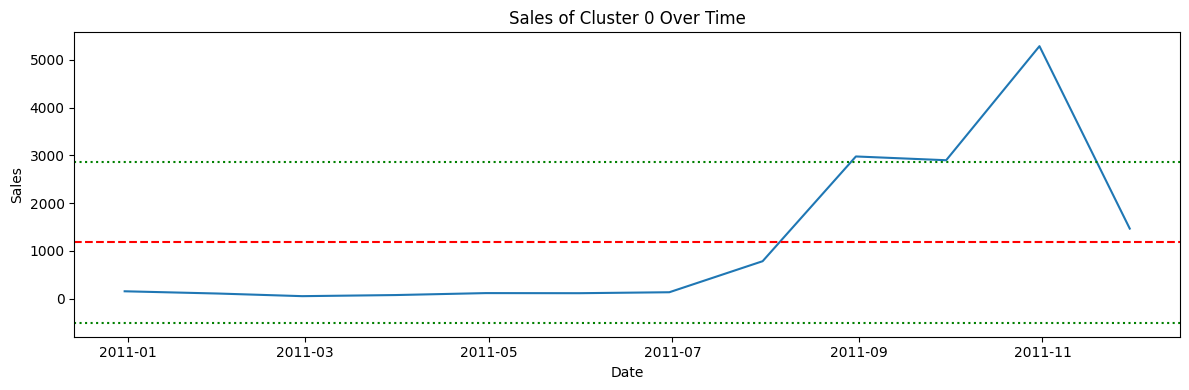

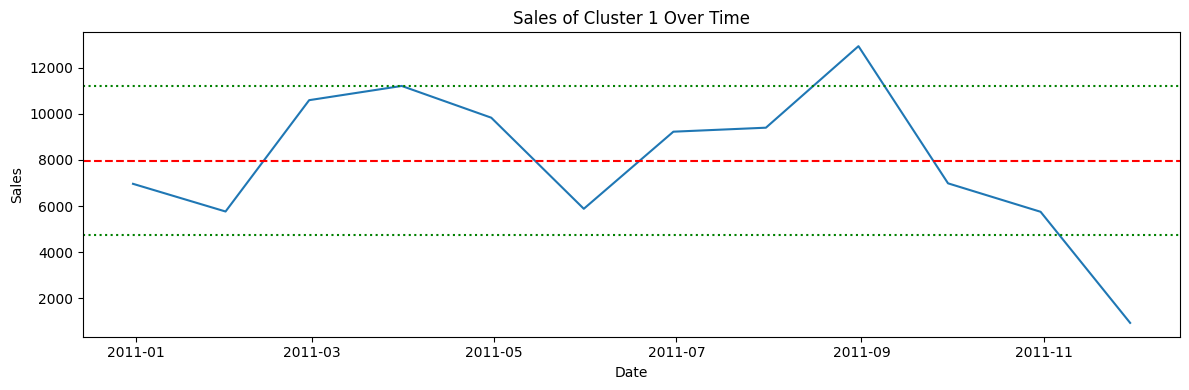

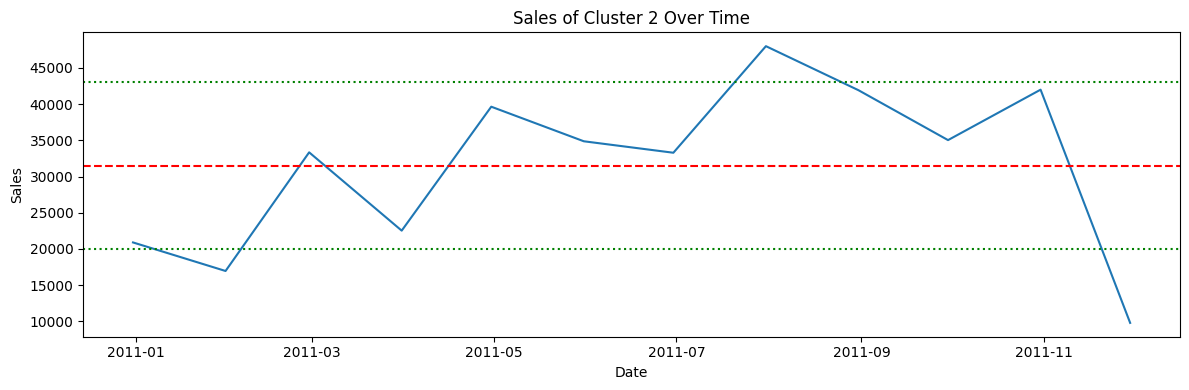

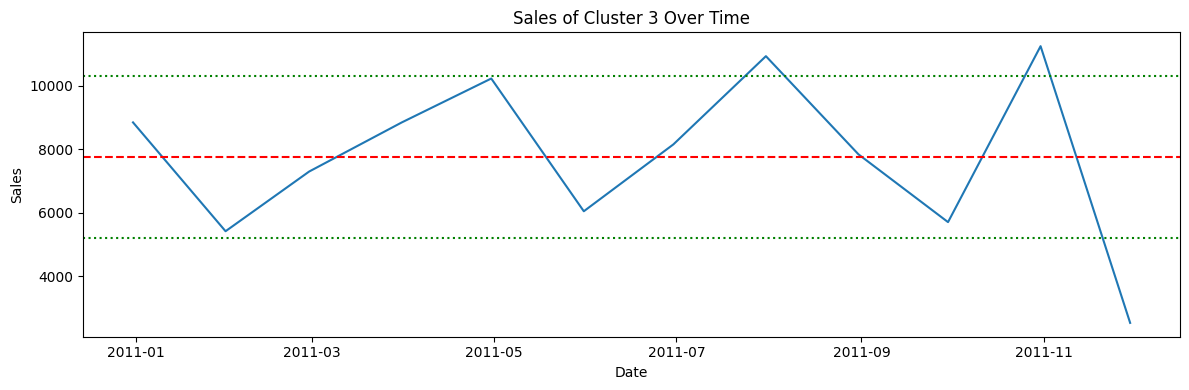

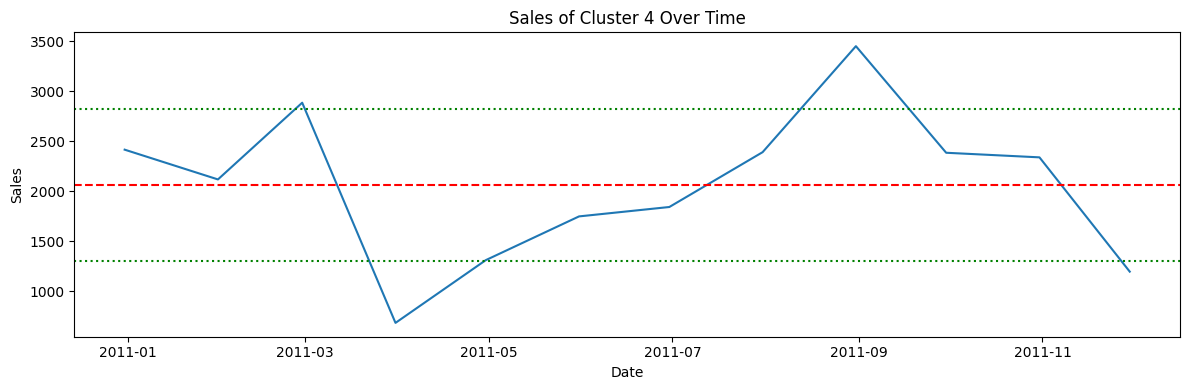

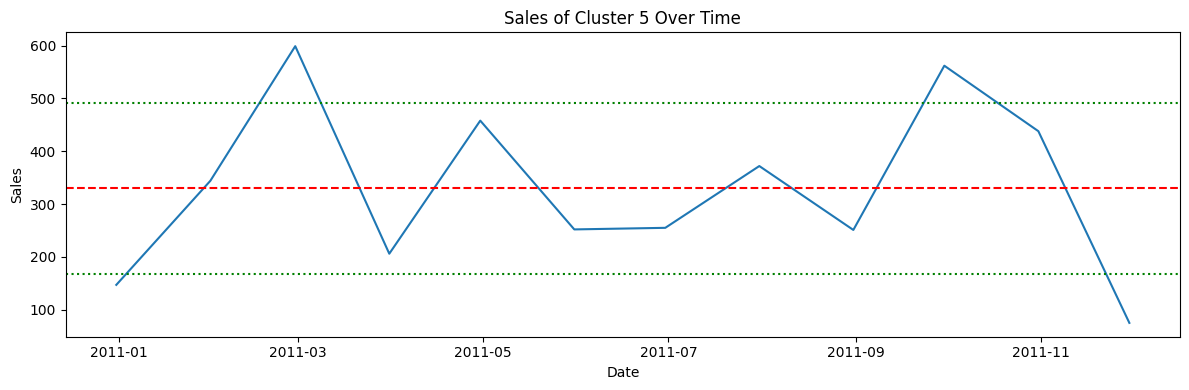

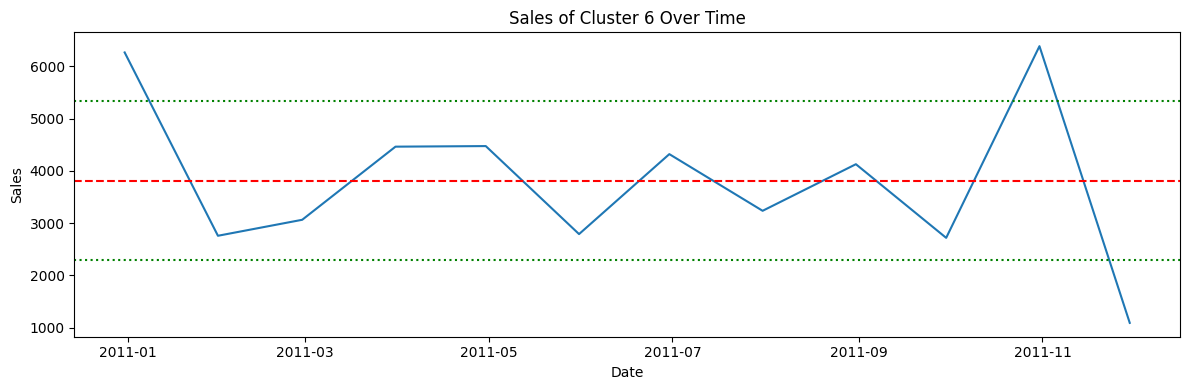

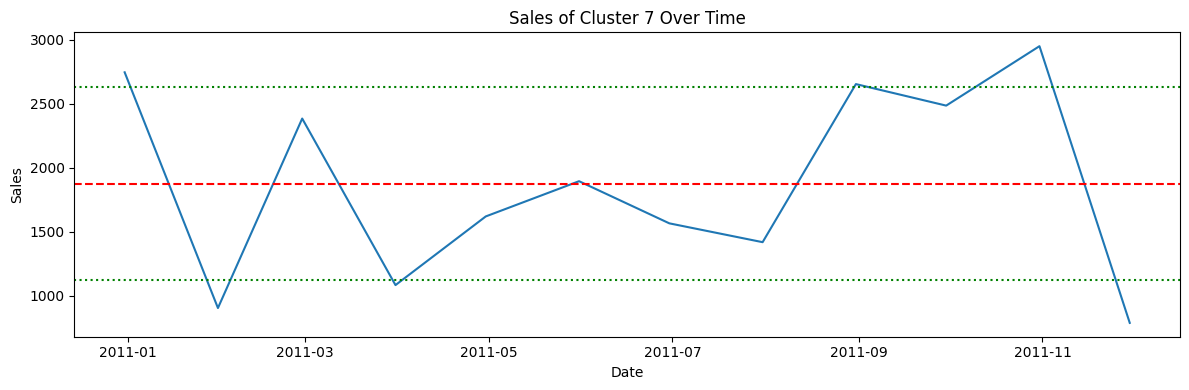

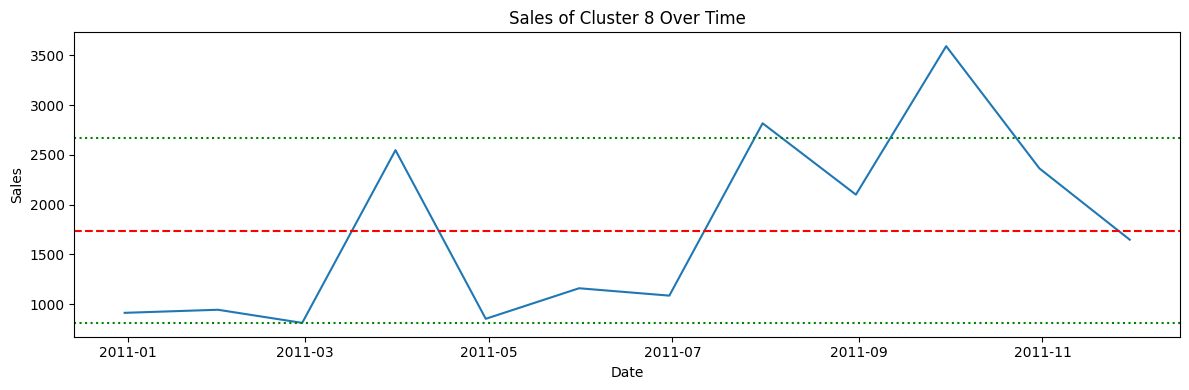

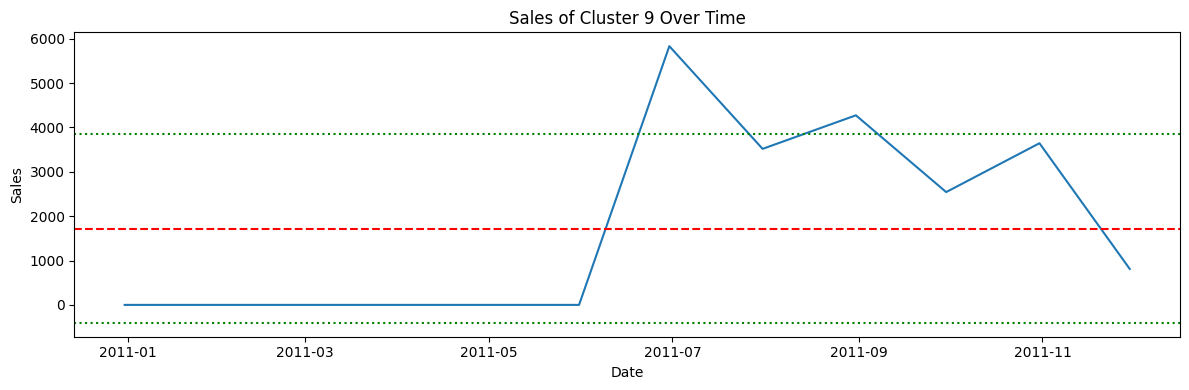

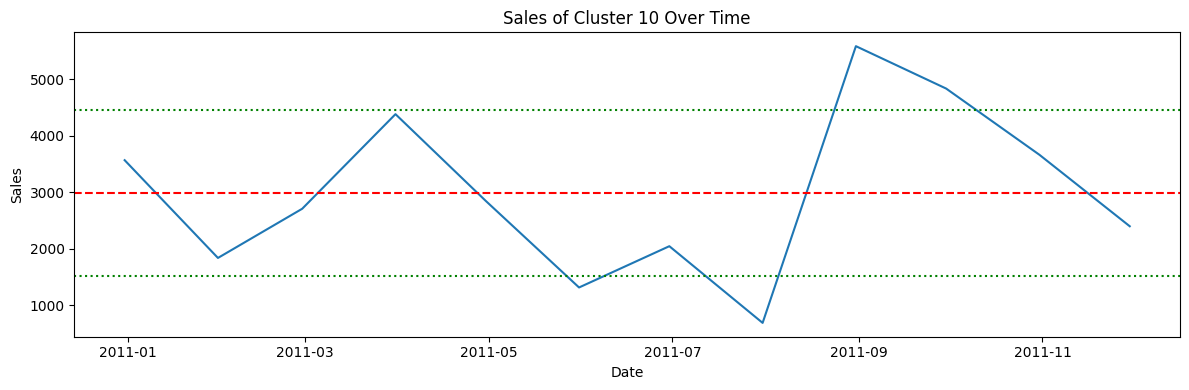

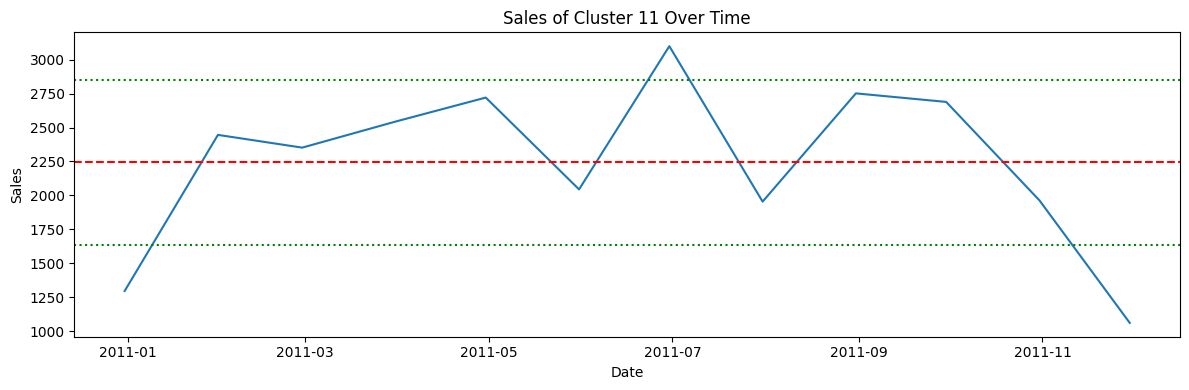

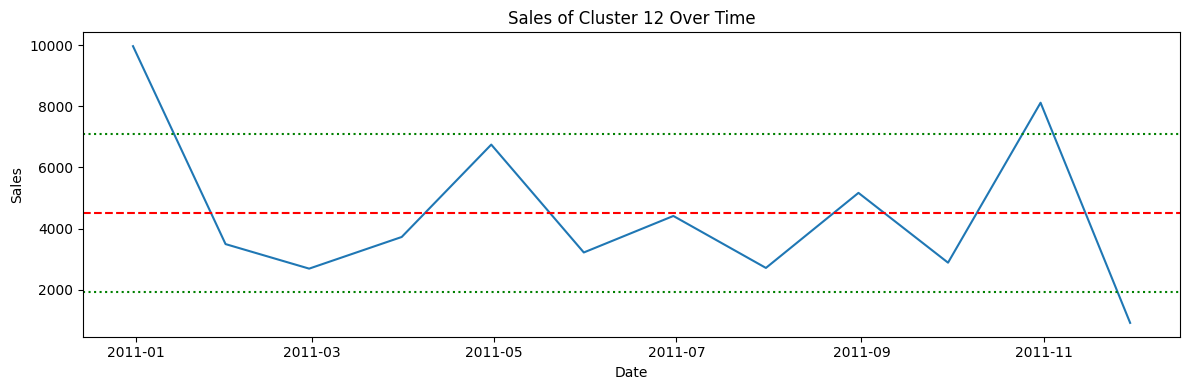

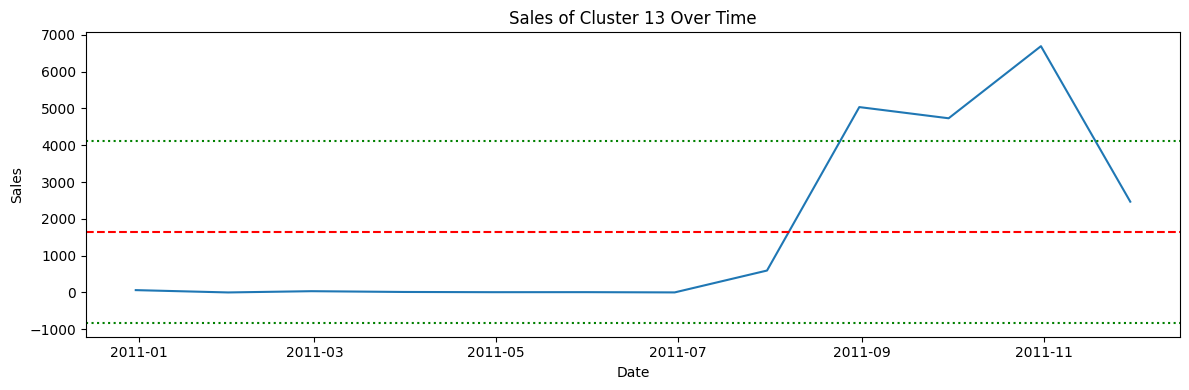

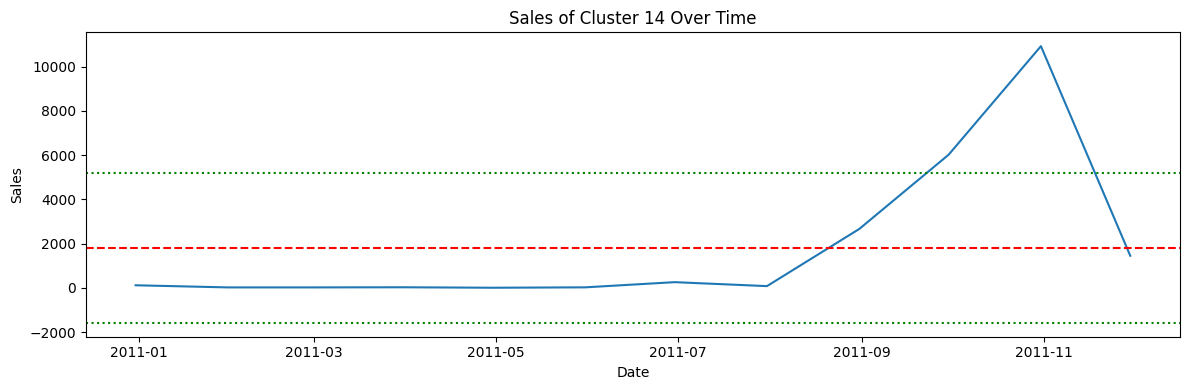

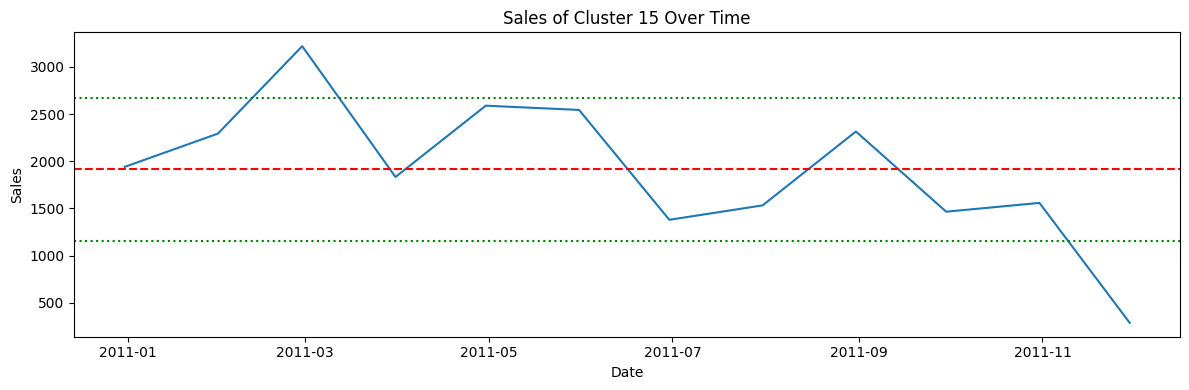

In [ ]:
# Assuming date_range is a list of date columns (not including 'Cluster_id')
for i, row in cluster_sales.iterrows():
    plt.figure(figsize=(12, 4))
    plt.plot(month_cols, row[month_cols])
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.title(f'Sales of Cluster {int(row["Cluster_id"])} Over Time')
    plt.tight_layout()
    plt.show()



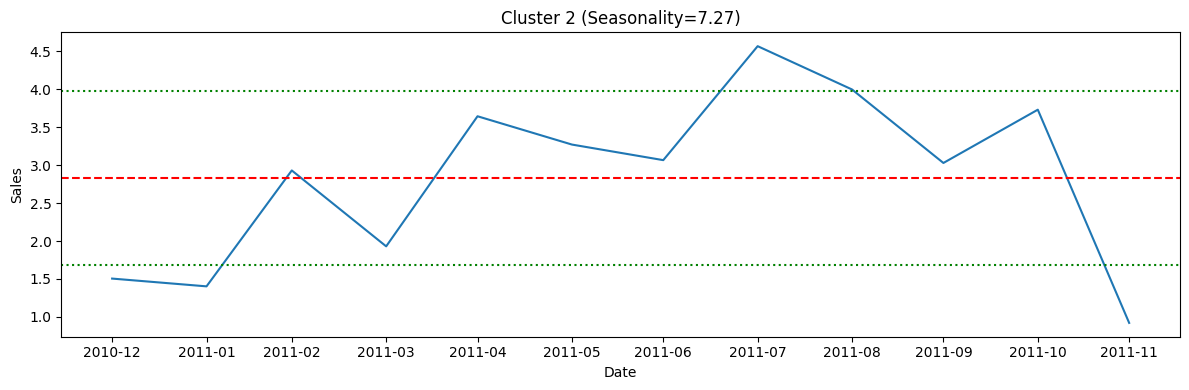

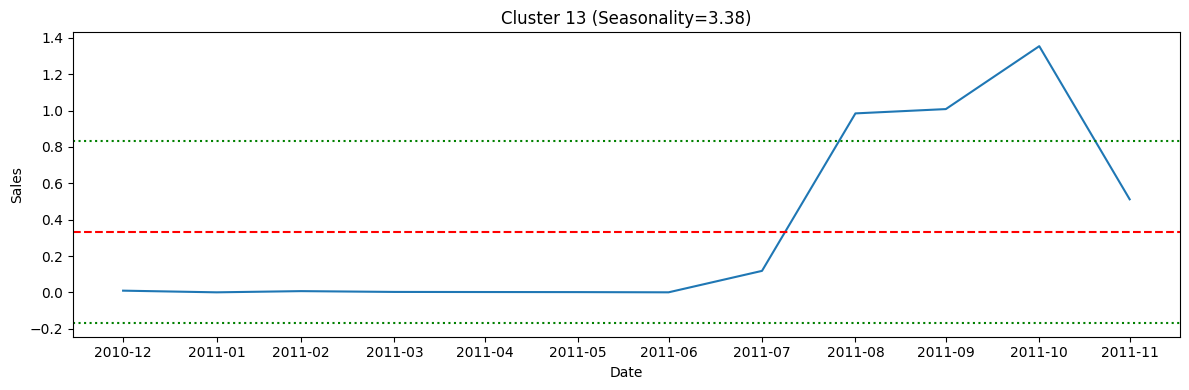

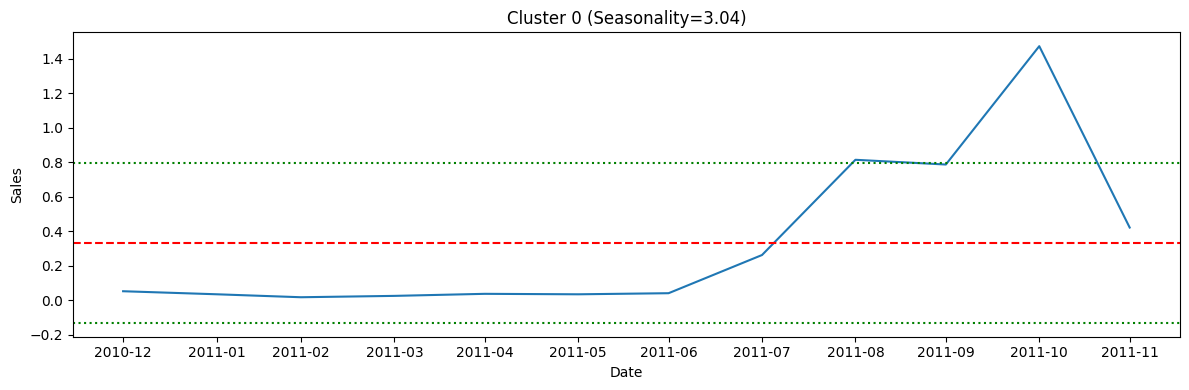

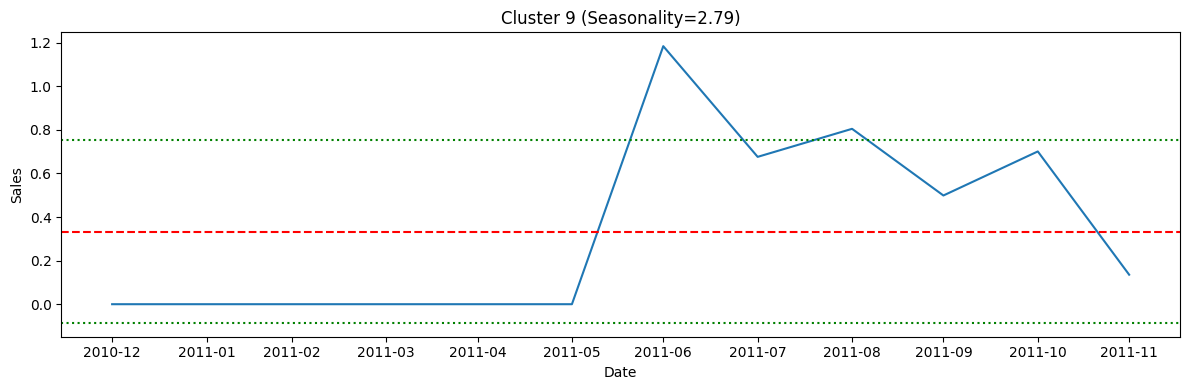

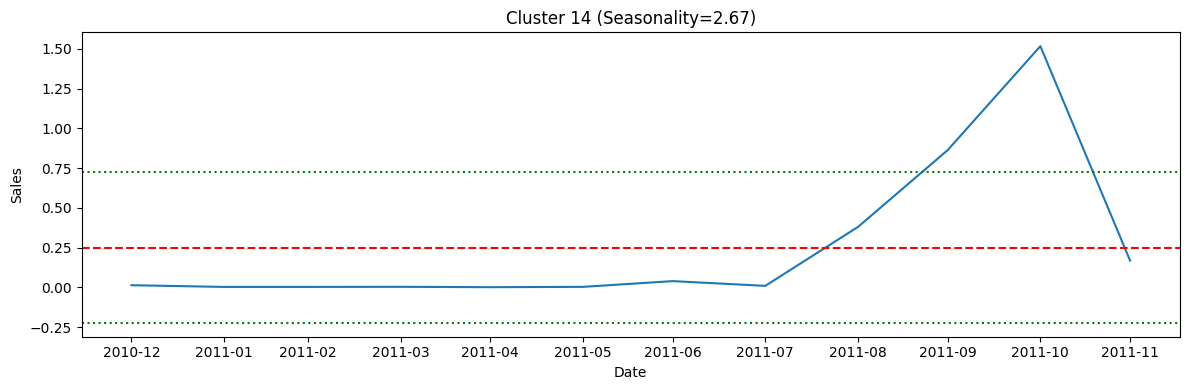

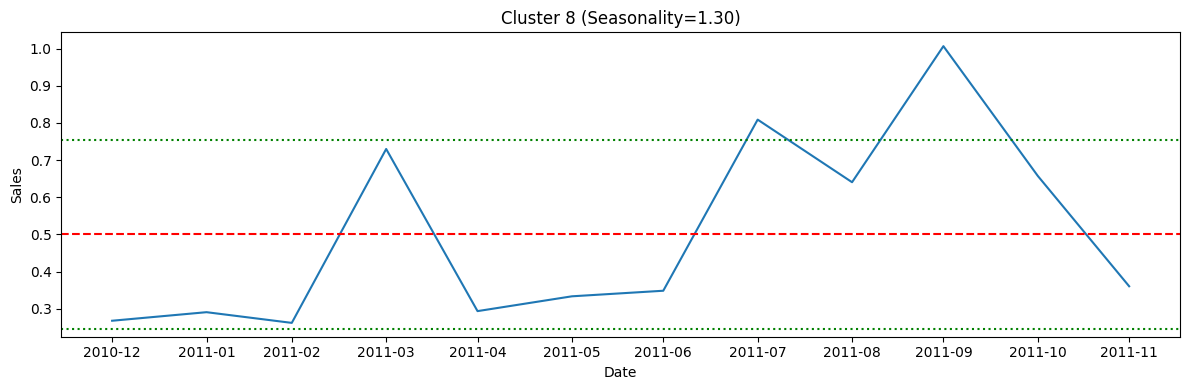

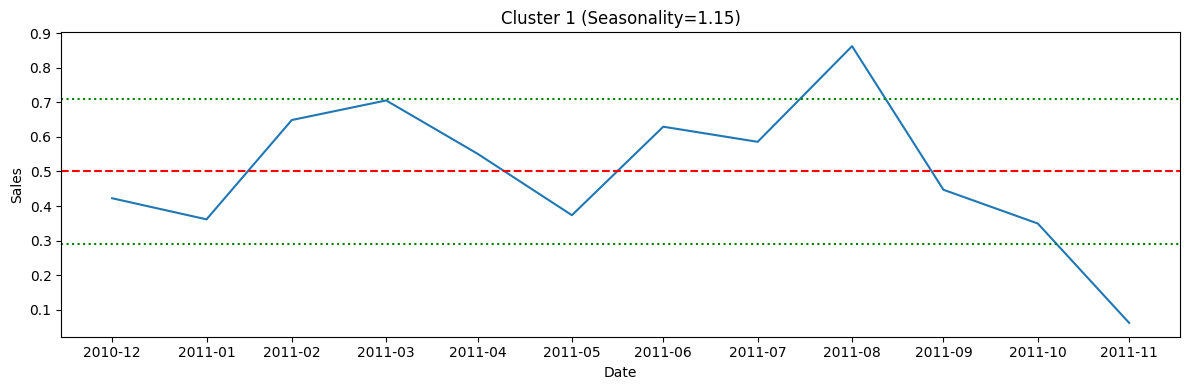

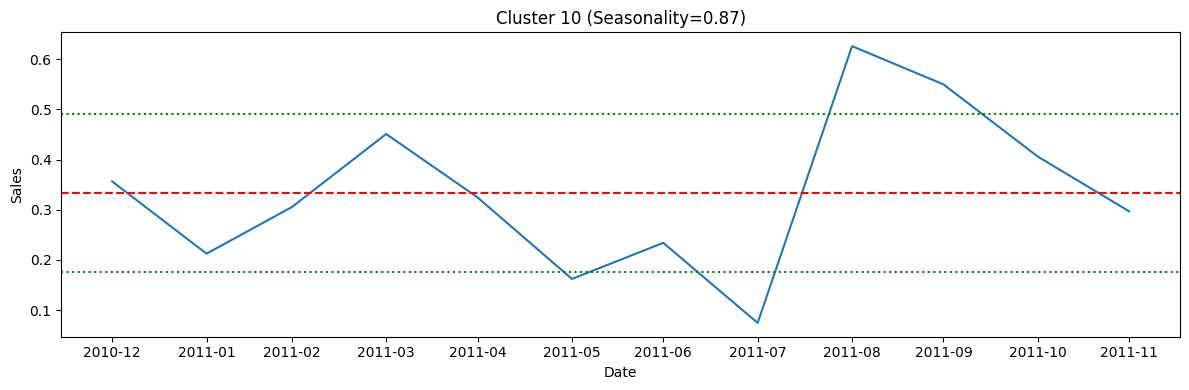

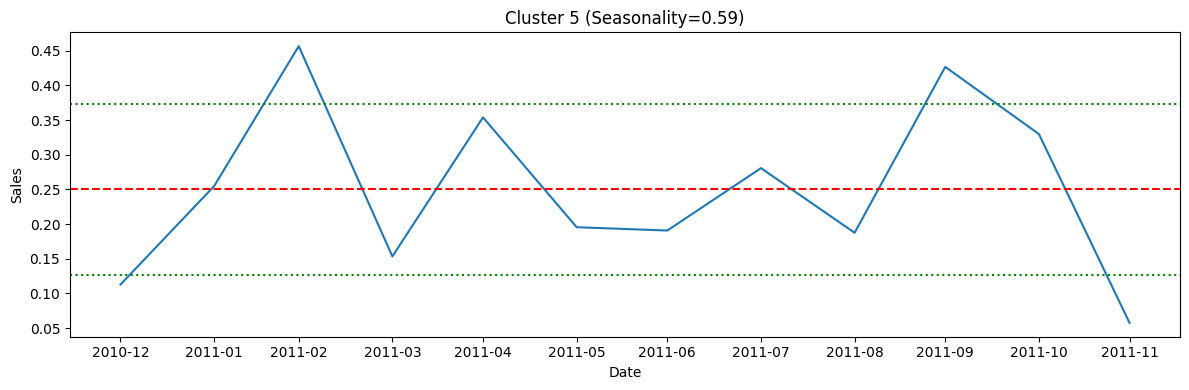

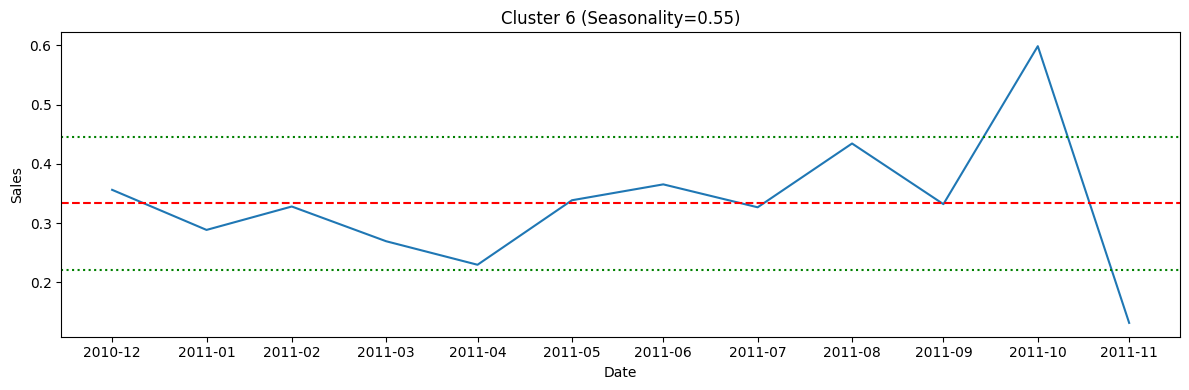

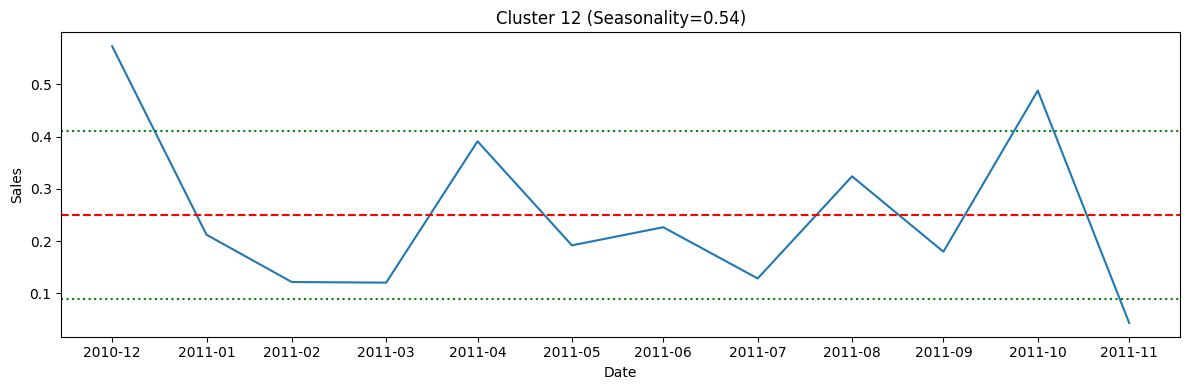

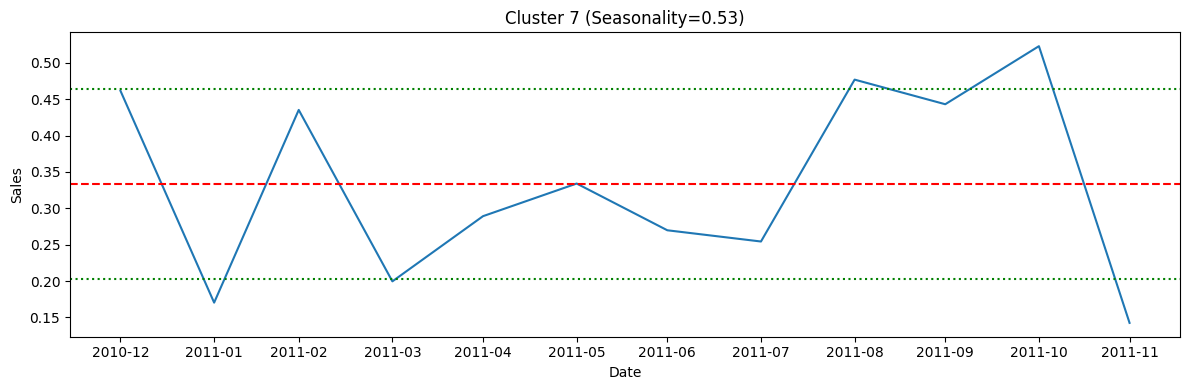

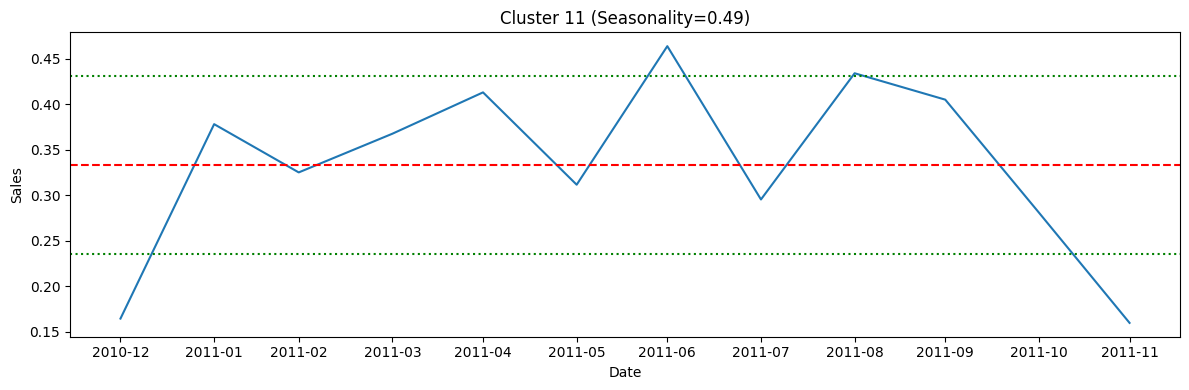

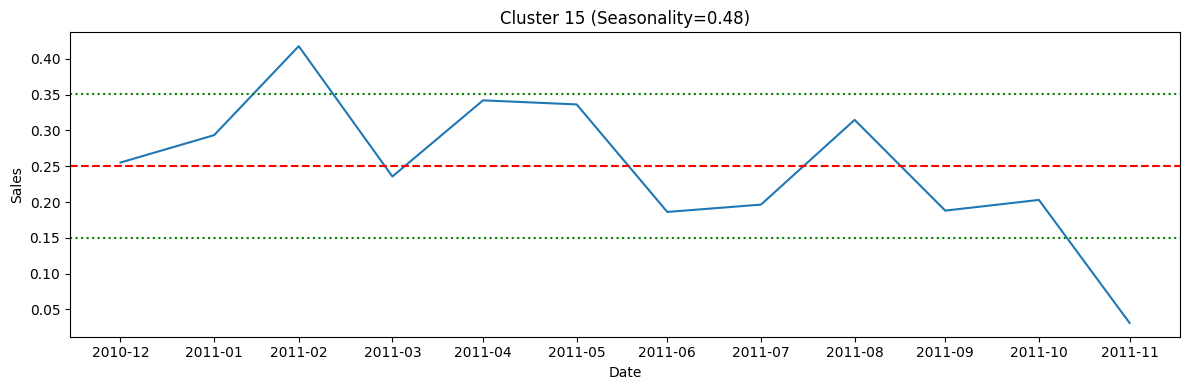

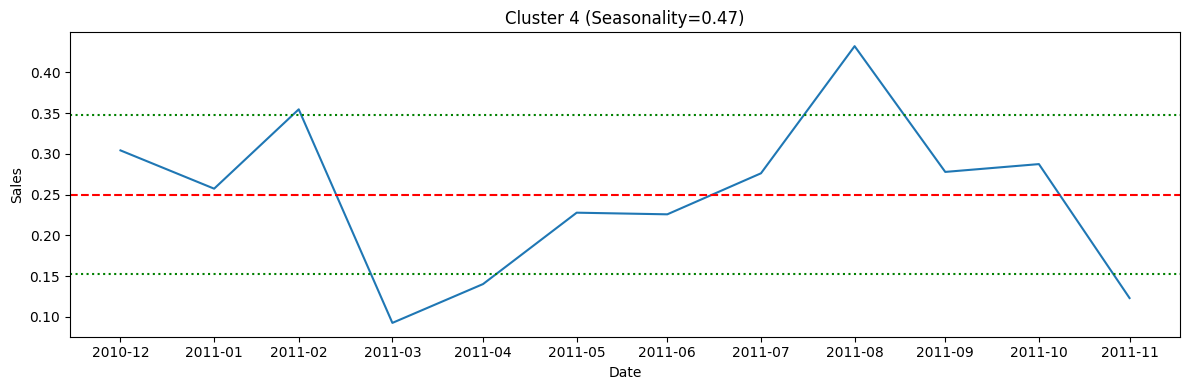

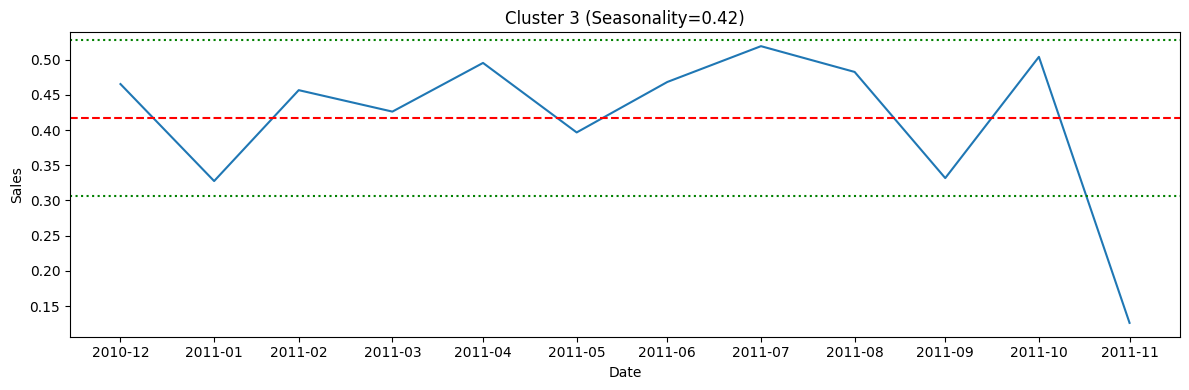

In [ ]:
import numpy as np
from matplotlib.dates import DateFormatter

seasonality_strengths = []

for i, row in cluster_sales.iterrows():
    sales = row[month_cols].values.astype(float)
    fft = np.fft.fft(sales - np.mean(sales))
    fft_power = np.abs(fft)
    # Ignore the zero-frequency (trend) component
    seasonal_power = fft_power[1:len(fft_power)//2].max()
    seasonality_strengths.append((i, seasonal_power))

# Sort clusters by seasonality strength (descending)
seasonality_strengths.sort(key=lambda x: x[1], reverse=True)

for idx, strength in seasonality_strengths:
    row = cluster_sales.loc[idx]
    plt.figure(figsize=(12, 4))
    plt.plot(month_cols, cluster_sales.loc[idx, month_cols])
    mean_sales = plt.axhline(row['MonthlySalesMean'], color='red', linestyle='--', label='Mean')
    lower_std_limit = plt.axhline(row['MonthlySalesMean'] + row['MonthlySalesStddev'], color='green', linestyle=':', label='+1 Stddev')
    upper_std_limit = plt.axhline(row['MonthlySalesMean'] - row['MonthlySalesStddev'], color='green', linestyle=':', label='-1 Stddev')
    plt.title(f"Cluster {int(cluster_sales.loc[idx, 'Cluster_id'])} (Seasonality={strength:.2f})")
    plt.xlabel('Date')
    plt.ylabel('Sales (means nothing)')
    plt.xticks(month_cols)
    ax = plt.gca()
    ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))
    plt.tight_layout()
    plt.show()